# Imports

In [1]:
import argparse
from pathlib import Path
from typing import Optional, Sequence

import xarray as xr
import numpy as np

from preproc import PreprocConfig, preprocess_neuropixel, trial_mean_over_window
import pandas as pd

# Importing Raw Data

The raw data is imported from the zarr files. It has been produced from the original paper of Nayebi and converted to zarr format.

In [2]:
zar_dir = Path("../AllenData/neuropixels.zarr/")
ds = xr.open_zarr(zar_dir, consolidated=True)
ds

<xarray.Dataset> Size: 10GB
Dimensions:                          (trials: 50, frame_id: 118,
                                      time_relative_to_stimulus_onset: 25,
                                      units: 8301, dim_0: 118, dim_1: 918,
                                      dim_2: 1174)
Coordinates:
  * frame_id                         (frame_id) int64 944B 0 1 2 ... 115 116 117
    image_selectivity_ns             (units) float64 66kB ...
    run_pval_ns                      (units) float64 66kB ...
    specimen_id                      (units) int64 66kB ...
    splithalf_r_mean                 (time_relative_to_stimulus_onset, units) float64 2MB ...
    splithalf_r_std                  (time_relative_to_stimulus_onset, units) float64 2MB ...
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 200B ...
  * trials                           (trials) int64 400B 1 2 3 4 ... 47 48 49 50
    unit_id                          (units) int64 66kB ...
    visual_area                      (units) object 66kB ...
Dimensions without coordinates: units, dim_0, dim_1, dim_2
Data variables:
    neural_data                      (trials, frame_id, time_relative_to_stimulus_onset, units) float64 10GB ...
    stimuli                          (dim_0, dim_1, dim_2) uint8 127MB ...

# Dataset Exploration

In [19]:
# compute the number of specimens for each area

area_count = ds[["visual_area", "specimen_id"]].to_dataframe().groupby("visual_area")["specimen_id"].nunique()
area_count

visual_area
VISal    24
VISam    26
VISl     24
VISp     32
VISpm    20
VISrl    28
Name: specimen_id, dtype: int64

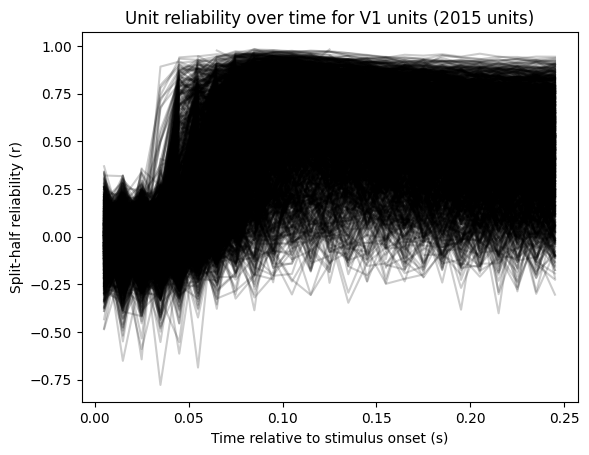

In [3]:
time_coord = ds["time_relative_to_stimulus_onset"].values  # (time,)
r_tu = ds["splithalf_r_mean"].values                       # (time, units)


# Select units that are in the visual area V1
v1_units_mask = ds.visual_area == "VISp"
r_tu_v1 = r_tu[:, v1_units_mask]


import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Plot all V1 units
ax.plot(time_coord, r_tu_v1, color="k", alpha=0.2)
ax.set_xlabel("Time relative to stimulus onset (s)")
ax.set_ylabel("Split-half reliability (r)")
ax.set_title(f"Unit reliability over time for V1 units ({r_tu_v1.shape[1]} units)")
plt.show()


 Nayebi's plot

In [45]:
import seaborn as sns
from scipy import stats

VISUAL_AREAS = ["VISp", "VISl", "VISal", "VISpm", "VISrl", "VISam"]
VISUAL_AREAS_HIER = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam"]

cmap = sns.color_palette("hls", len(VISUAL_AREAS_HIER))
colors = [cmap[i] for i in range(len(VISUAL_AREAS_HIER))]
VISUAL_AREA_COLOR_MAP = {v: colors[v_idx] for v_idx, v in enumerate(VISUAL_AREAS_HIER)}

def plot_reliability_over_time(
    r_tu,
    fraction_of_max=True
):
    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    time = np.arange(0, 25 * 10, 10)

    for v in VISUAL_AREAS:

        area_mask = ds.visual_area == v
        reliabilities = r_tu[:, area_mask]

        median = np.nanmedian(reliabilities, axis=1)

        if fraction_of_max:
            median = median / np.max(median)

        sem = stats.sem(reliabilities, axis=1, nan_policy="omit")

        ax.fill_between(time, median + sem, median - sem, label=v, alpha=0.8, color=VISUAL_AREA_COLOR_MAP[v])

    if fraction_of_max:
        ax.set_ylabel("Fraction of Maximum Split-half Reliability (Pearson's R)")
    else:    
        ax.set_ylabel("Split-half Reliability (Pearson's R)")
        
    ax.set_xlabel("Time (ms)")
    ax.legend(loc="upper left", frameon=False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xticks(np.arange(0, 25 * 10, 40))


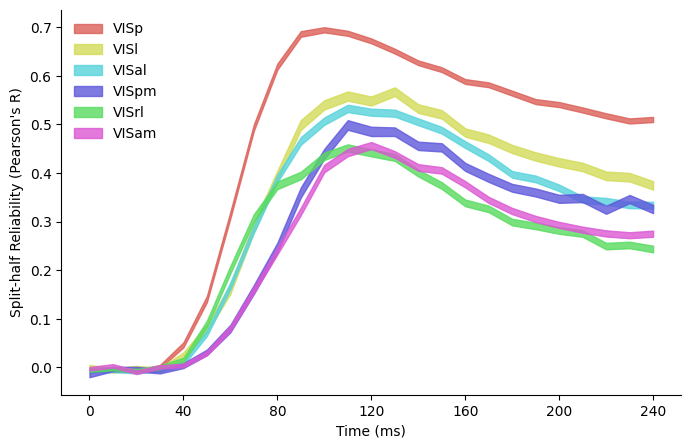

In [46]:
plot_reliability_over_time(r_tu, fraction_of_max=False)

The plot below is exactly the same one as in Nayebi's paper (Fig.1.B.). 

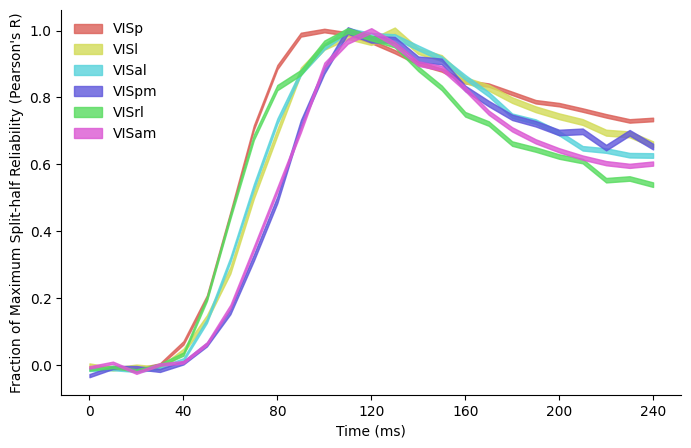

In [47]:
plot_reliability_over_time(r_tu, fraction_of_max=True)

# Preprocessing: Allen data to Nayebi

In [9]:
config = PreprocConfig(apply_running_filter=False, equalize_to_p75=False, window_median_thr = 0.29)
index_df, p75 = preprocess_neuropixel(
    ds,
    out_root="PreprocData",
    out_format="npy",           # saves one .npy per (specimen, area)
    index_name="index.csv",     # and a CSV index with paths to the .npy files
    config=config,
    save_design_matrices=True,  # optional (images, units), averaged across trials
    design_root="PreprocData/design_mats",
)

Saved 39 specimen-area arrays to PreprocData
P75 thresholds (units/specimen) by area: {'V1': 85, 'LM': 51, 'AL': 85, 'PM': 54, 'RL': 67, 'AM': 70}


producing the Nayebis table 1.

In [10]:
index_df.groupby('area').agg(
    total_specimens=('specimen_id','nunique'),
    total_units=('n_units','sum')
)

,total_specimens,total_units
area,,
AL,6,742
AM,7,586
LM,6,369
PM,5,386
RL,7,565
V1,8,748


Original table 1 from Nayebi's paper:

| area | total_specimens | total_units |
|------|-----------------|-------------|
| AL   | 6               | 396         |
| AM   | 7               | 257         |
| LM   | 6               | 162         |
| PM   | 5               | 175         |
| RL   | 7               | 299         |
| V1   | 8               | 442         |

In [ ]:
# # import index df if not produced in the notebook

# index_df = pd.read_csv('PreprocData/index.csv')

# index_df.groupby('area').agg(
#     total_specimens=('specimen_id','nunique'),
#     total_units=('n_units','sum')
# )